### diversity experiments

basically this has the experiments proper at top and like, plotting shit below that

In [8]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from decision_diffuser import DecisionDiffuserTrainConfig
from janner_diffuser import JannerDiffuserTrainConfig
from decision_diffuser import eval_model as dd_eval
from janner_diffuser import eval_model as janner_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
env = 'gridland'
n_size = 5
memory = 512
horizon = 512 # for generation so must be power of 2
num_envs = 250
trials = 25
num_episodes = 1
temperature = 0.5
n_exec_steps = 32
render = True

# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
from janner_diffuser import JannerDiffuserTrainConfig
config = JannerDiffuserTrainConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
env = GridLand(n_size=5,timeout = 500)
env.reset()
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(50))
#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))

Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 1273517.37it/s]

(50, 500, 2)
# of Unique Training Trajectories: 42


In [9]:
### Changes replanning length, with access to full memory
# loads config, modifies to work w/given parameters
param_search = [512,415,350,275,200,125,75,25]
#param_search = [512,200]

print('===== Changing N Executed Steps - Full Memory =====')

for param in param_search:
        # recording stuff
        completion_rate = []
        num_unique_succ_gen_traj = []
        num_unique_novel_succ_gen_traj = []
        percent_succ_gen_traj_novel = []
        print('==== Running Eval: N-Steps =' , param, '====')
        for i in range(trials):
                config = JannerDiffuserTrainConfig()
                config.memory = 512
                config.horizon = horizon
                config.num_envs = num_envs
                config.num_episodes = num_episodes
                config.n_exec_steps = param
                config.env = env
                config.inpaint = False
                config.gridland = True
                config.n_size = n_size
                config.pad = False
                config.gen_horizon = horizon
                config.toy_env = True
                config.open_loop_invdyn = False

                # loads environment
                envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
                obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

                # loads inverse dynamics
                invdyn = ToyEnvInvDyn()
                #invdyn.load(config.invdyn_path)

                # loads agent 
                # --------------- Network Architecture -----------------# 
                nn_diffusion = JannerUNet1d(
                        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
                        timestep_emb_type="positional", attention=False, kernel_size=5)


                # ----------------- Masking -------------------
                # NOTE - not sure what any of this does (should figure out!)
                fix_mask = torch.zeros((config.horizon, obs_dim)) 
                fix_mask[0, :] = 1. # for the starting/current state
                loss_weight = torch.ones((config.horizon, obs_dim))

                # --------------- difuse --------------------
                agent = DiscreteDiffusionSDE(
                        nn_diffusion, None,
                        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
                        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)
                agent.load('trained_models/JannerInpaint-hFull-Clean-gridland-n5-b1af52cfdiffusion_ckpt_latest.pt')
                
                envs.reset()
                avg_completion,trajectories, replans = janner_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
                #print(trajectories[0].shape)
                
                env = GridLand(n_size=n_size,timeout = 500)
                env.reset()
                traj_visitations = []
                trajectories = np.array(trajectories)
                trajectories = np.transpose(trajectories,(0,2,1,3))
                #print(trajectories.shape)
                for ep in trajectories:
                        for trajectory in ep:
                                #print(trajectory.shape)
                                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                                traj_visitations.append(visited_intersections_idx)
                generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
                filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
                completion_rate.append(avg_completion)
                num_unique_succ_gen_traj.append(len(filtered_trajectories))
                num_unique_novel_succ_gen_traj.append(len(filtered_trajectories-training_trajectory_visitations))
                percent_succ_gen_traj_novel.append(len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
        print('Avg. Completion Rate:',np.mean(completion_rate),'| STD:',np.sqrt(np.var(completion_rate)))
        print('Avg. # of Unique Generated Trajectories:',np.mean(num_unique_succ_gen_traj),'| STD:',np.sqrt(np.var(num_unique_succ_gen_traj)))
        print('Avg. # of Novel  Generated Trajectories:', np.mean(num_unique_novel_succ_gen_traj),'| STD:',np.sqrt(np.var(num_unique_novel_succ_gen_traj)))
        print('Avg. % of Generated Trajectories Novel:', np.mean(percent_succ_gen_traj_novel),'| STD:',np.sqrt(np.var(percent_succ_gen_traj_novel)))
                #training_trajectory_visitations



===== Changing N Executed Steps - Full Memory =====
==== Running Eval: N-Steps = 512 ====


/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

Avg. Completion Rate: 0.9948799999999999 | STD: 0.00400319872102298
Avg. # of Unique Generated Trajectories: 46.12 | STD: 1.557433786714543
Avg. # of Novel  Generated Trajectories: 4.72 | STD: 1.3422369388450015
Avg. % of Generated Trajectories Novel: 0.10160874286406962 | STD: 0.025153366821072064
==== Running Eval: N-Steps = 415 ====


100%|██████████| 1/1 [00:19<00:00, 19.23s/it]


Avg. Completion Rate: 0.9947199999999999 | STD: 0.004485710646040384
Avg. # of Unique Generated Trajectories: 45.56 | STD: 1.5252540771950096
Avg. # of Novel  Generated Trajectories: 4.32 | STD: 1.6666133324799728
Avg. % of Generated Trajectories Novel: 0.0938864558282087 | STD: 0.034202986169392095
==== Running Eval: N-Steps = 350 ====


100%|██████████| 1/1 [00:18<00:00, 18.52s/it]


Avg. Completion Rate: 0.99312 | STD: 0.006041986428319751
Avg. # of Unique Generated Trajectories: 45.28 | STD: 1.8004443895883038
Avg. # of Novel  Generated Trajectories: 4.12 | STD: 1.84
Avg. % of Generated Trajectories Novel: 0.08971285642304387 | STD: 0.03751525978013626
==== Running Eval: N-Steps = 275 ====


100%|██████████| 1/1 [00:18<00:00, 18.47s/it]


Avg. Completion Rate: 0.9520000000000001 | STD: 0.014221111067704916
Avg. # of Unique Generated Trajectories: 45.4 | STD: 1.6492422502470643
Avg. # of Novel  Generated Trajectories: 4.88 | STD: 1.727888885316414
Avg. % of Generated Trajectories Novel: 0.10658031429847856 | STD: 0.03468441504067969
==== Running Eval: N-Steps = 200 ====


100%|██████████| 1/1 [00:24<00:00, 24.82s/it]


Avg. Completion Rate: 0.8888000000000001 | STD: 0.018863721796082568
Avg. # of Unique Generated Trajectories: 55.04 | STD: 3.1556932677305634
Avg. # of Novel  Generated Trajectories: 17.68 | STD: 3.0818176454813155
Avg. % of Generated Trajectories Novel: 0.3193962345222639 | STD: 0.03934842794929256
==== Running Eval: N-Steps = 125 ====


100%|██████████| 1/1 [00:30<00:00, 30.75s/it]


Avg. Completion Rate: 0.8947200000000001 | STD: 0.017443669338760136
Avg. # of Unique Generated Trajectories: 61.6 | STD: 3.521363372331802
Avg. # of Novel  Generated Trajectories: 28.56 | STD: 3.9097826026519686
Avg. % of Generated Trajectories Novel: 0.4618373151022355 | STD: 0.04141892340276205
==== Running Eval: N-Steps = 75 ====


100%|██████████| 1/1 [00:46<00:00, 46.86s/it]


Avg. Completion Rate: 0.40415999999999996 | STD: 0.029251570897987682
Avg. # of Unique Generated Trajectories: 34.76 | STD: 2.627241899787684
Avg. # of Novel  Generated Trajectories: 9.2 | STD: 2.039607805437114
Avg. % of Generated Trajectories Novel: 0.2633242236887267 | STD: 0.04903241081831282
==== Running Eval: N-Steps = 25 ====


100%|██████████| 1/1 [01:57<00:00, 117.76s/it]


Avg. Completion Rate: 0.07919999999999999 | STD: 0.0163560386402087
Avg. # of Unique Generated Trajectories: 15.2 | STD: 3.0463092423455636
Avg. # of Novel  Generated Trajectories: 6.96 | STD: 2.288755120147195
Avg. % of Generated Trajectories Novel: 0.4550664983451361 | STD: 0.10512474700932317


In [10]:
### Changes replanning length, no memory
# loads config, modifies to work w/given parameters
param_search = [512,415,350,275,200,125,75,25]
#param_search = [512,200]

print('===== Changing N Executed Steps - No Memory =====')

for param in param_search:
        # recording stuff
        completion_rate = []
        num_unique_succ_gen_traj = []
        num_unique_novel_succ_gen_traj = []
        percent_succ_gen_traj_novel = []
        print('==== Running Eval: N-Steps =' , param, '====')
        for i in range(trials):
                config = JannerDiffuserTrainConfig()
                config.memory = 1
                config.horizon = horizon
                config.num_envs = num_envs
                config.num_episodes = num_episodes
                config.n_exec_steps = param
                config.env = env
                config.inpaint = False
                config.gridland = True
                config.n_size = n_size
                config.pad = False
                config.gen_horizon = horizon
                config.toy_env = True
                config.open_loop_invdyn = False

                # loads environment
                envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
                obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

                # loads inverse dynamics
                invdyn = ToyEnvInvDyn()
                #invdyn.load(config.invdyn_path)

                # loads agent 
                # --------------- Network Architecture -----------------# 
                nn_diffusion = JannerUNet1d(
                        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
                        timestep_emb_type="positional", attention=False, kernel_size=5)


                # ----------------- Masking -------------------
                # NOTE - not sure what any of this does (should figure out!)
                fix_mask = torch.zeros((config.horizon, obs_dim)) 
                fix_mask[0, :] = 1. # for the starting/current state
                loss_weight = torch.ones((config.horizon, obs_dim))

                # --------------- difuse --------------------
                agent = DiscreteDiffusionSDE(
                        nn_diffusion, None,
                        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
                        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)
                agent.load('trained_models/JannerInpaint-hFull-Clean-gridland-n5-b1af52cfdiffusion_ckpt_latest.pt')
                
                envs.reset()
                avg_completion,trajectories, replans = janner_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
                #print(trajectories[0].shape)
                
                env = GridLand(n_size=n_size,timeout = 500)
                env.reset()
                traj_visitations = []
                trajectories = np.array(trajectories)
                trajectories = np.transpose(trajectories,(0,2,1,3))
                #print(trajectories.shape)
                for ep in trajectories:
                        for trajectory in ep:
                                #print(trajectory.shape)
                                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                                traj_visitations.append(visited_intersections_idx)
                generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
                filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
                completion_rate.append(avg_completion)
                num_unique_succ_gen_traj.append(len(filtered_trajectories))
                num_unique_novel_succ_gen_traj.append(len(filtered_trajectories-training_trajectory_visitations))
                percent_succ_gen_traj_novel.append(len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
        print('Avg. Completion Rate:',np.mean(completion_rate),'| STD:',np.sqrt(np.var(completion_rate)))
        print('Avg. # of Unique Generated Trajectories:',np.mean(num_unique_succ_gen_traj),'| STD:',np.sqrt(np.var(num_unique_succ_gen_traj)))
        print('Avg. # of Novel  Generated Trajectories:', np.mean(num_unique_novel_succ_gen_traj),'| STD:',np.sqrt(np.var(num_unique_novel_succ_gen_traj)))
        print('Avg. % of Generated Trajectories Novel:', np.mean(percent_succ_gen_traj_novel),'| STD:',np.sqrt(np.var(percent_succ_gen_traj_novel)))
                #training_trajectory_visitations



===== Changing N Executed Steps - No Memory =====
==== Running Eval: N-Steps = 512 ====


100%|██████████| 1/1 [00:12<00:00, 12.33s/it]


Avg. Completion Rate: 0.99472 | STD: 0.00462618633433631
Avg. # of Unique Generated Trajectories: 45.8 | STD: 1.854723699099141
Avg. # of Novel  Generated Trajectories: 4.32 | STD: 2.0341091416145796
Avg. % of Generated Trajectories Novel: 0.09274055081871763 | STD: 0.0405192387333679
==== Running Eval: N-Steps = 415 ====


100%|██████████| 1/1 [00:19<00:00, 19.74s/it]


Avg. Completion Rate: 0.9945599999999999 | STD: 0.0038995384342252644
Avg. # of Unique Generated Trajectories: 45.48 | STD: 1.4176036117335482
Avg. # of Novel  Generated Trajectories: 3.84 | STD: 1.4051334456200237
Avg. % of Generated Trajectories Novel: 0.08361428561805044 | STD: 0.029043253571043207
==== Running Eval: N-Steps = 350 ====


100%|██████████| 1/1 [00:18<00:00, 18.81s/it]


Avg. Completion Rate: 0.99616 | STD: 0.004305159695063591
Avg. # of Unique Generated Trajectories: 45.88 | STD: 2.4053274205396655
Avg. # of Novel  Generated Trajectories: 4.48 | STD: 2.137662274541982
Avg. % of Generated Trajectories Novel: 0.09556091181944402 | STD: 0.04240125325572815
==== Running Eval: N-Steps = 275 ====


100%|██████████| 1/1 [00:16<00:00, 16.53s/it]


Avg. Completion Rate: 0.9988800000000001 | STD: 0.002122639865827458
Avg. # of Unique Generated Trajectories: 59.64 | STD: 3.0708956348270777
Avg. # of Novel  Generated Trajectories: 20.16 | STD: 2.5088642848906755
Avg. % of Generated Trajectories Novel: 0.3368505037855127 | STD: 0.026403649533250723
==== Running Eval: N-Steps = 200 ====


100%|██████████| 1/1 [00:22<00:00, 22.88s/it]


Avg. Completion Rate: 0.9992 | STD: 0.0016000000000000014
Avg. # of Unique Generated Trajectories: 76.68 | STD: 12.18431778968359
Avg. # of Novel  Generated Trajectories: 39.0 | STD: 13.558761005342634
Avg. % of Generated Trajectories Novel: 0.495894972654712 | STD: 0.08207495892194608
==== Running Eval: N-Steps = 125 ====


100%|██████████| 1/1 [00:28<00:00, 28.89s/it]


Avg. Completion Rate: 0.99952 | STD: 0.001299846144741755
Avg. # of Unique Generated Trajectories: 71.2 | STD: 3.1240998703626617
Avg. # of Novel  Generated Trajectories: 34.08 | STD: 2.8414081016284864
Avg. % of Generated Trajectories Novel: 0.47797939695851027 | STD: 0.023115032208218814
==== Running Eval: N-Steps = 75 ====


100%|██████████| 1/1 [00:39<00:00, 39.66s/it]


Avg. Completion Rate: 0.99952 | STD: 0.001299846144741755
Avg. # of Unique Generated Trajectories: 84.16 | STD: 4.912677477710093
Avg. # of Novel  Generated Trajectories: 49.76 | STD: 4.735229667080573
Avg. % of Generated Trajectories Novel: 0.5903426362521264 | STD: 0.03229791083990004
==== Running Eval: N-Steps = 25 ====


100%|██████████| 1/1 [01:59<00:00, 119.92s/it]


Avg. Completion Rate: 0.9993599999999999 | STD: 0.0018521339044464378
Avg. # of Unique Generated Trajectories: 98.84 | STD: 13.235346614274974
Avg. # of Novel  Generated Trajectories: 65.6 | STD: 13.893883546366725
Avg. % of Generated Trajectories Novel: 0.6583665560021567 | STD: 0.045505401885877074


In [11]:
### changes memory, short replanning length
# loads config, modifies to work w/given parameters
param_search = [512,415,350,275,200,125,75,25]
#param_search = [512,200]

print('===== Changing N Executed Steps - No Memory =====')

for param in param_search:
        # recording stuff
        completion_rate = []
        num_unique_succ_gen_traj = []
        num_unique_novel_succ_gen_traj = []
        percent_succ_gen_traj_novel = []
        print('==== Running Eval: N-Steps =' , param, '====')
        for i in range(trials):
                config = JannerDiffuserTrainConfig()
                config.memory = param
                config.horizon = horizon
                config.num_envs = num_envs
                config.num_episodes = num_episodes
                config.n_exec_steps = 50
                config.env = env
                config.inpaint = False
                config.gridland = True
                config.n_size = n_size
                config.pad = False
                config.gen_horizon = horizon
                config.toy_env = True
                config.open_loop_invdyn = False

                # loads environment
                envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
                obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

                # loads inverse dynamics
                invdyn = ToyEnvInvDyn()
                #invdyn.load(config.invdyn_path)

                # loads agent 
                # --------------- Network Architecture -----------------# 
                nn_diffusion = JannerUNet1d(
                        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
                        timestep_emb_type="positional", attention=False, kernel_size=5)


                # ----------------- Masking -------------------
                # NOTE - not sure what any of this does (should figure out!)
                fix_mask = torch.zeros((config.horizon, obs_dim)) 
                fix_mask[0, :] = 1. # for the starting/current state
                loss_weight = torch.ones((config.horizon, obs_dim))

                # --------------- difuse --------------------
                agent = DiscreteDiffusionSDE(
                        nn_diffusion, None,
                        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
                        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)
                agent.load('trained_models/JannerInpaint-hFull-Clean-gridland-n5-b1af52cfdiffusion_ckpt_latest.pt')
                
                envs.reset()
                avg_completion,trajectories, replans = janner_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
                #print(trajectories[0].shape)
                
                env = GridLand(n_size=n_size,timeout = 500)
                env.reset()
                traj_visitations = []
                trajectories = np.array(trajectories)
                trajectories = np.transpose(trajectories,(0,2,1,3))
                #print(trajectories.shape)
                for ep in trajectories:
                        for trajectory in ep:
                                #print(trajectory.shape)
                                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                                traj_visitations.append(visited_intersections_idx)
                generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
                filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
                completion_rate.append(avg_completion)
                num_unique_succ_gen_traj.append(len(filtered_trajectories))
                num_unique_novel_succ_gen_traj.append(len(filtered_trajectories-training_trajectory_visitations))
                percent_succ_gen_traj_novel.append(len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
        print('Avg. Completion Rate:',np.mean(completion_rate),'| STD:',np.sqrt(np.var(completion_rate)))
        print('Avg. # of Unique Generated Trajectories:',np.mean(num_unique_succ_gen_traj),'| STD:',np.sqrt(np.var(num_unique_succ_gen_traj)))
        print('Avg. # of Novel  Generated Trajectories:', np.mean(num_unique_novel_succ_gen_traj),'| STD:',np.sqrt(np.var(num_unique_novel_succ_gen_traj)))
        print('Avg. % of Generated Trajectories Novel:', np.mean(percent_succ_gen_traj_novel),'| STD:',np.sqrt(np.var(percent_succ_gen_traj_novel)))
                #training_trajectory_visitations



===== Changing N Executed Steps - No Memory =====
==== Running Eval: N-Steps = 512 ====


100%|██████████| 1/1 [01:03<00:00, 63.67s/it]


Avg. Completion Rate: 0.37120000000000003 | STD: 0.02999733321480428
Avg. # of Unique Generated Trajectories: 48.2 | STD: 4.098780306383839
Avg. # of Novel  Generated Trajectories: 25.8 | STD: 4.2708313008125245
Avg. % of Generated Trajectories Novel: 0.5324247990536697 | STD: 0.048489068333879615
==== Running Eval: N-Steps = 415 ====


100%|██████████| 1/1 [01:03<00:00, 63.37s/it]


Avg. Completion Rate: 0.36080000000000007 | STD: 0.021614809737770073
Avg. # of Unique Generated Trajectories: 45.92 | STD: 2.9518807563992144
Avg. # of Novel  Generated Trajectories: 24.2 | STD: 3.2741411087489802
Avg. % of Generated Trajectories Novel: 0.5252146933513977 | STD: 0.046441896782440206
==== Running Eval: N-Steps = 350 ====


100%|██████████| 1/1 [01:03<00:00, 63.68s/it]


Avg. Completion Rate: 0.3659200000000001 | STD: 0.029418252837311736
Avg. # of Unique Generated Trajectories: 46.8 | STD: 4.604345773288536
Avg. # of Novel  Generated Trajectories: 24.36 | STD: 3.803997896949997
Avg. % of Generated Trajectories Novel: 0.5186192398303285 | STD: 0.04677134617840835
==== Running Eval: N-Steps = 275 ====


100%|██████████| 1/1 [01:03<00:00, 63.08s/it]


Avg. Completion Rate: 0.36992 | STD: 0.030612311248907693
Avg. # of Unique Generated Trajectories: 45.2 | STD: 5.059644256269407
Avg. # of Novel  Generated Trajectories: 22.88 | STD: 4.320370354495087
Avg. % of Generated Trajectories Novel: 0.502263290986184 | STD: 0.04971246488530447
==== Running Eval: N-Steps = 200 ====


100%|██████████| 1/1 [01:03<00:00, 63.30s/it]


Avg. Completion Rate: 0.32159999999999994 | STD: 0.029718680993610736
Avg. # of Unique Generated Trajectories: 45.16 | STD: 3.4604046006211466
Avg. # of Novel  Generated Trajectories: 24.96 | STD: 3.078701024783017
Avg. % of Generated Trajectories Novel: 0.5514941579316256 | STD: 0.03956376088073801
==== Running Eval: N-Steps = 125 ====


100%|██████████| 1/1 [01:03<00:00, 63.86s/it]


Avg. Completion Rate: 0.27584000000000003 | STD: 0.030993780021159083
Avg. # of Unique Generated Trajectories: 41.4 | STD: 4.127953488110059
Avg. # of Novel  Generated Trajectories: 21.92 | STD: 3.6651875804656986
Avg. % of Generated Trajectories Novel: 0.527538653986365 | STD: 0.0559353951917136
==== Running Eval: N-Steps = 75 ====


100%|██████████| 1/1 [01:02<00:00, 62.65s/it]


Avg. Completion Rate: 0.24144000000000002 | STD: 0.022595716408204458
Avg. # of Unique Generated Trajectories: 41.08 | STD: 4.7742643412362495
Avg. # of Novel  Generated Trajectories: 21.84 | STD: 4.961290154788369
Avg. % of Generated Trajectories Novel: 0.5262943619132681 | STD: 0.06841275791436316
==== Running Eval: N-Steps = 25 ====


100%|██████████| 1/1 [01:03<00:00, 63.51s/it]


Avg. Completion Rate: 0.6041599999999999 | STD: 0.03128153448921585
Avg. # of Unique Generated Trajectories: 77.04 | STD: 4.34952871010182
Avg. # of Novel  Generated Trajectories: 49.56 | STD: 4.0701842710128
Avg. % of Generated Trajectories Novel: 0.6427874727415162 | STD: 0.02916375755095532


## plotting starts here

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# dumps all the data here so stuff doesn't get confused
replan_sweep = [512,415,350,275,200,125,75,25]
memory_sweep = [512,415,350,275,200,125,75,25]

# replan w/full memory stuff
## average
num_unique_traj_avg_full_memory = [46.12,45.56,45.28,45.4,55.04,61.6,34.76,15.2]
num_novel_traj_avg_full_memory = [4.72,4.32,4.12,4.88,17.68,28.56,9.2,6.96]
percent_gen_novel_avg_full_memory = np.array([.101,.0938,.0897,.106,.319,.461,.263,.455])*100
completion_avg_full_memory = np.array([.994,.994,.993,.952,.888,.894,.404,.0791])*100
## std
num_unique_traj_std_full_memory = np.array([1.55,1.52,1.8,1.64,3.15,3.52,2.62,3.04])
num_novel_traj_std_full_memory = np.array([1.34,1.666,1.84,1.727,3.08,3.909,2.039,2.288])
percent_gen_novel_std_full_memory = np.array([.0251,.0342,.0375,.0346,.0393,.0414,.049,.105])*100
completion_std_full_memory = np.array([.004,.0045,.00604,.0142,.0188,.0174,.0293,.0163])*100


# replan w/no memory stuff
## average
num_unique_traj_avg_no_memory = [45.8,45.48,45.88,59.64,78.68,71.2,84.16,98.84]
num_novel_traj_avg_no_memory = [4.32,3.84,4.48,20.16,39.0,34.08,49.76,65.6]
percent_gen_novel_avg_no_memory = np.array([.0927,.0836,.0955,.3368,.495,.4779,.5903,.6583])*100
completion_avg_no_memory = np.array([.99472,.995,.996,.998,.999,.999,.999,.999])*100
## std
num_unique_traj_std_no_memory = np.array([1.85,1.41,2.4,3.07,12.18,3.12,4.9,13.2])
num_novel_traj_std_no_memory = np.array([2.03,1.4,2.13,2.5,13.55,2.84,4.73,13.89])
percent_gen_novel_std_no_memory = np.array([.04,.029,.042,.026,.082,.023,.032,.045])*100
completion_std_no_memory = np.array([.00462,.0038,.0043,.002,.0016,.0012,.0012,.0018])*100

# memory w/fixed horizons stuff
## average
completion_avg_50_replan = np.array([.371,.360,.365,.369,.321,.275,.241,.604])*100
num_unique_traj_avg_50_replan = [48.2,45.92,46.8,45.2,45.16,41.4,41.08,77.04]
num_novel_traj_avg_50_replan = [25.8,24.2,24.4,22.8,24.96,21.92,21.84,49.56]
percent_gen_novel_avg_50_replan = np.array([.53,.52,.51,.50,.55,.52,.52,.64])*100
## std
completion_std_50_replan = np.array([.029,.021,.029,.03,.029,.03,.022,.03])*100
num_unique_traj_std_50_replan = np.array([4.0,2.95,4.6,5.05,3.4,4.12,4.77,4.35])
num_novel_traj_std_50_replan = np.array([4.27,3.27,3.8,4.32,3.07,3.66,4.96,4.07])
percent_gen_novel_std_50_replan = np.array([.048,.046,.046,.049,.039,.055,.068,.029])*100



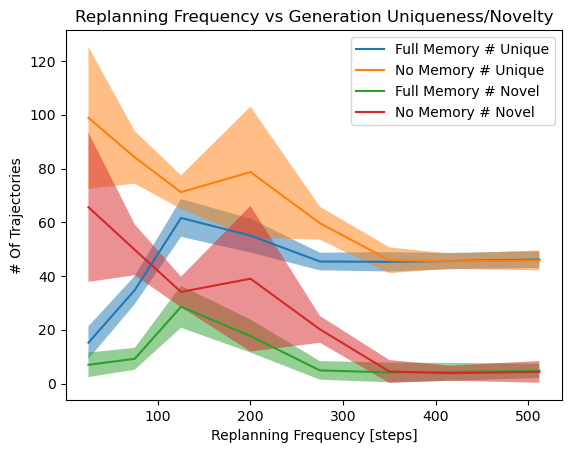

In [19]:
# plots changing execution length vs novelty  
param_search = [512,415,350,275,200,125,75,25]
plt.plot(replan_sweep,num_unique_traj_avg_full_memory,label='Full Memory # Unique')
plt.fill_between(replan_sweep,num_unique_traj_avg_full_memory-num_unique_traj_std_full_memory*2,num_unique_traj_avg_full_memory+num_unique_traj_std_full_memory*2,alpha=0.5)
plt.plot(replan_sweep,num_unique_traj_avg_no_memory,label='No Memory # Unique')
plt.fill_between(replan_sweep,num_unique_traj_avg_no_memory-num_unique_traj_std_no_memory*2,num_unique_traj_avg_no_memory+num_unique_traj_std_no_memory*2,alpha=0.5)

plt.plot(replan_sweep,num_novel_traj_avg_full_memory,label='Full Memory # Novel')
plt.fill_between(replan_sweep,num_novel_traj_avg_full_memory-num_novel_traj_std_full_memory*2,num_novel_traj_avg_full_memory+num_novel_traj_std_full_memory*2,alpha=0.5)
plt.plot(replan_sweep,num_novel_traj_avg_no_memory,label='No Memory # Novel')
plt.fill_between(replan_sweep,num_novel_traj_avg_no_memory-num_novel_traj_std_no_memory*2,num_novel_traj_avg_no_memory+num_novel_traj_std_no_memory*2,alpha=0.5)
plt.title('Replanning Frequency vs Generation Uniqueness/Novelty')
plt.xlabel('Replanning Frequency [steps]')
plt.ylabel('# Of Trajectories')
plt.legend()


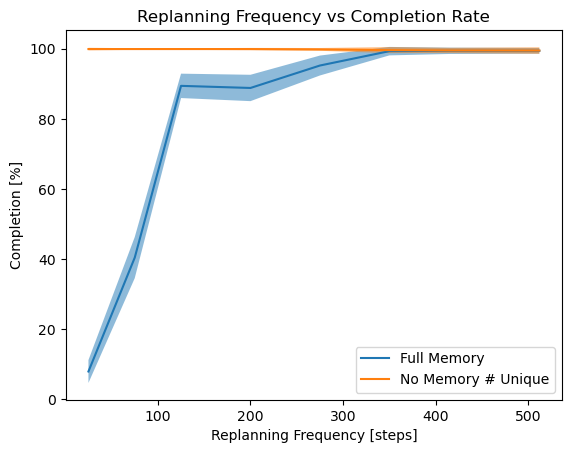

In [22]:
param_search = [512,415,350,275,200,125,75,25]
plt.plot(replan_sweep,completion_avg_full_memory,label='Full Memory')
plt.fill_between(replan_sweep,completion_avg_full_memory-completion_std_full_memory*2,completion_avg_full_memory+completion_std_full_memory*2,alpha=0.5)
plt.plot(replan_sweep,completion_avg_no_memory,label='No Memory # Unique')
plt.fill_between(replan_sweep,completion_avg_no_memory-completion_std_no_memory*2,completion_avg_no_memory+completion_std_no_memory*2,alpha=0.5)

plt.title('Replanning Frequency vs Completion Rate')
plt.xlabel('Replanning Frequency [steps]')
plt.ylabel('Completion [%]')
plt.legend()

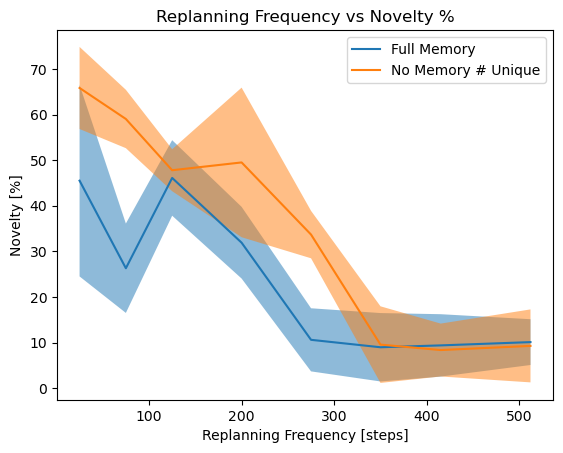

In [28]:
param_search = [512,415,350,275,200,125,75,25]
plt.plot(replan_sweep,percent_gen_novel_avg_full_memory,label='Full Memory')
plt.fill_between(replan_sweep,percent_gen_novel_avg_full_memory-percent_gen_novel_std_full_memory*2,percent_gen_novel_avg_full_memory+percent_gen_novel_std_full_memory*2,alpha=0.5)
plt.plot(replan_sweep,percent_gen_novel_avg_no_memory,label='No Memory # Unique')
plt.fill_between(replan_sweep,percent_gen_novel_avg_no_memory-percent_gen_novel_std_no_memory*2,percent_gen_novel_avg_no_memory+percent_gen_novel_std_no_memory*2,alpha=0.5)

plt.title('Replanning Frequency vs Novelty %')
plt.xlabel('Replanning Frequency [steps]')
plt.ylabel('Novelty [%]')
plt.legend()

/tmp/ipykernel_3870245/2621784637.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


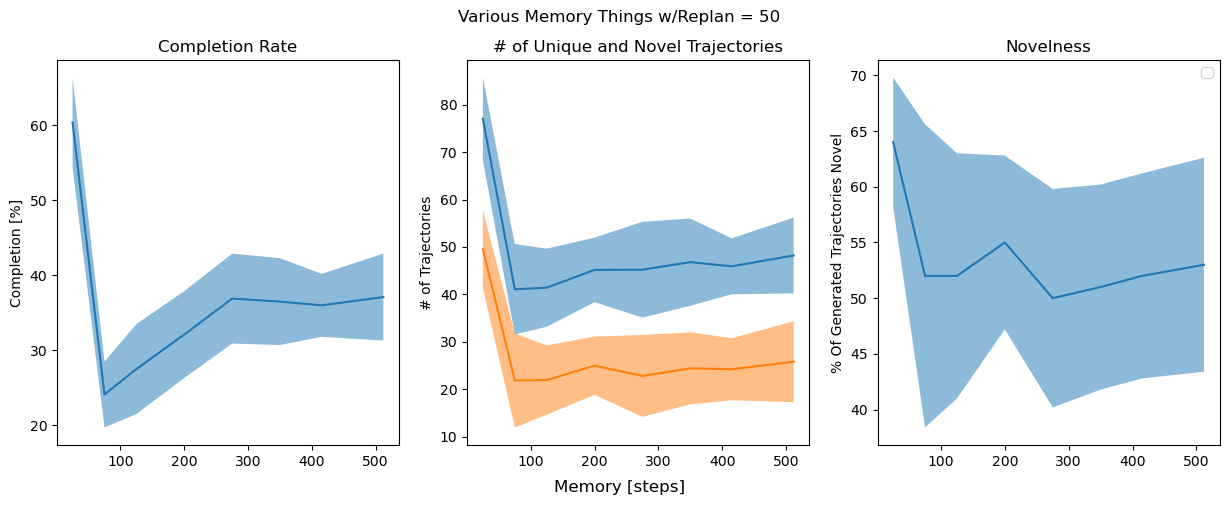

In [26]:
# plots some stuff vs memory
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(memory_sweep,completion_avg_50_replan)
axes[0].fill_between(replan_sweep,completion_avg_50_replan-completion_std_50_replan*2,completion_avg_50_replan+completion_std_50_replan*2,alpha=0.5)
axes[0].set_ylabel('Completion [%]')
axes[0].set_title('Completion Rate')
axes[1].plot(memory_sweep,num_unique_traj_avg_50_replan)
axes[1].fill_between(replan_sweep,num_unique_traj_avg_50_replan-num_unique_traj_std_50_replan*2,num_unique_traj_avg_50_replan+num_unique_traj_std_50_replan*2,alpha=0.5)

axes[1].plot(memory_sweep,num_novel_traj_avg_50_replan)
axes[1].fill_between(replan_sweep,num_novel_traj_avg_50_replan-num_novel_traj_std_50_replan*2,num_novel_traj_avg_50_replan+num_novel_traj_std_50_replan*2,alpha=0.5)

axes[1].set_ylabel('# of Trajectories')
axes[1].set_title('# of Unique and Novel Trajectories')
axes[2].plot(memory_sweep,percent_gen_novel_avg_50_replan)
axes[2].fill_between(replan_sweep,percent_gen_novel_avg_50_replan-percent_gen_novel_std_50_replan*2,percent_gen_novel_avg_50_replan+percent_gen_novel_std_50_replan*2,alpha=0.5)

axes[2].set_ylabel('% Of Generated Trajectories Novel')
axes[2].set_title('Novelness')
fig.suptitle('Various Memory Things w/Replan = 50')
fig.supxlabel('Memory [steps]')
#plt.xlabel('Memory Length [steps]')
#plt.ylabel('Completion Rate [%]')
plt.legend()

In [ ]:
# prediction horizion stuff

